![banner](https://github.com/priyammaz/PyTorch-Adventures/blob/main/src/visuals/rl_banner.png?raw=true)

# Synchronous Advantage Actor Critic (A2C)

Now that we have learned about [Actor Critic](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Deep%20RL%20Policy%20Models/Vanilla%20Actor%20Critic/actor_critic.ipynb), its time to upgrade it in a few meaningful ways! The cool part is you already know everything to do this!

Our previous implementation was a simple Actor-Critic trying to maximize the policy gradient using a simple 1-step TD error. Haven't we already come up with better ways to improve this in the past?

#### 1-Step Only?

As we know, a 1-step estimate is high bias/low variance. But we have already explored methods to improve this:

- Monte Carlo: Complete a full trajectory (expensive because we have to wait a full episode to update)
- N-Step: Complete N-Steps in an environment and use that + Bootstrapping future returns after N steps as our estimate
- ($\lambda$) Methods: Use an exponential decay to interpolate between our 1-Step and Monte Carlo

#### High Variance Estimates

As we make our number of steps larger we will end up with higher variance estimates and noisy returns due to the stochasticity of the environment. So in [REINFORCE with Baseline](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Deep%20RL%20Policy%20Models/REINFORCE%20with%20Baseline/reinforce_with_baseline.ipynb) we learned that using our Advantage function rather than raw returns was better, as we are trying to maximize the value of a specific action over the average at that state, rather than just some random value. 

#### Synchronous

This is the new part of our implementation, Synchronous environments. The problem with our attempts so far is that we are basically training on one environment at a time. This means we are limited to the exploration of our agent on that environment specifically. 

But, what if we could explore multiple at the same time and pool that information together? This should allow for more robust estimates of our environment! There are two ways to do this:

- **Synchronous**: This is the A2C algorithm, where if we have $N$ environments, we step through all of them at the same time!
- **Asynchronous**: This is the A3C algorithm, our agents just do whatever they want independently in each environment and every few iterations share their knowledge with the rest

The A3C Algorithm actually came first, and the A2C was proposed as a simplified variant. From what I have seen A2C typically performs better and is easier to implement! I may do A3C later, but there isn't much interesting going on thats different from what I have here, we just have to leverage ```torch.multiprocessing``` to ensure all the threads are running independently. 

### Setting up Synchronous Environments

So how do we actually have multiple environments? Thats easy, we can just create a simple wrapper that does the following:

- When asking for a state, we will get a state for each environment
- When taking a step with an action, we have to provide each environment an action

This wont be full featured, just an example!

In [13]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium.vector import SyncVectorEnv, AsyncVectorEnv
import matplotlib.pyplot as plt
import pickle 
from IPython.display import Video

class SynchronousEnv:
    def __init__(self, num_envs, env_name):

        self.num_envs = num_envs
        self.env_name = env_name
        self.envs = [gym.make(env_name) for _ in range(num_envs)]
        self.observation_space = self.envs[0].observation_space
        self.action_space = self.envs[0].action_space
        self.closed = False

    def reset(self):
        observations = [env.reset()[0] for env in self.envs]
        return np.stack(observations, axis=0)

    def step(self, actions):

        if len(actions) != self.num_envs:
            raise ValueError(f"Expected {self.num_envs} actions, got {len(actions)}")
        
        results = [env.step(action) for env, action in zip(self.envs, actions)]
        observations, rewards, terminal, truncate, infos = zip(*results)
        
        return (np.stack(observations, axis=0),
                np.array(rewards, dtype=np.float32),
                np.array(terminal, dtype=np.bool_),
                np.array(truncate, dtype=np.bool_),
                list(infos))

envs = SynchronousEnv(num_envs=4, env_name="LunarLander-v3")
state = envs.reset()
print("State:")
print(state.shape, "\n")

print("Experience Tuple")
envs.step([0,0,0,0])

State:
(4, 8) 

Experience Tuple


(array([[-2.5307655e-03,  1.3862895e+00, -1.2800133e-01, -5.6015873e-01,
          2.9074175e-03,  2.8693166e-02,  0.0000000e+00,  0.0000000e+00],
        [ 5.3663255e-04,  1.4042733e+00,  2.7131757e-02, -1.6053592e-01,
         -6.0836569e-04, -6.0829362e-03,  0.0000000e+00,  0.0000000e+00],
        [ 1.4319802e-02,  1.4226389e+00,  7.2420901e-01,  2.4752451e-01,
         -1.6406560e-02, -1.6235353e-01,  0.0000000e+00,  0.0000000e+00],
        [-3.9071082e-03,  1.4137539e+00, -1.9760922e-01,  5.0130725e-02,
          4.4851829e-03,  4.4301935e-02,  0.0000000e+00,  0.0000000e+00]],
       dtype=float32),
 array([-1.3742079 , -2.192033  , -0.41292956,  0.4686749 ], dtype=float32),
 array([False, False, False, False]),
 array([False, False, False, False]),
 [{}, {}, {}, {}])

You see that our state is now a ```(4 x 8)``` matrix. This is because we wanted 4 environments, and each environments state is represented by 8 numbers in the LunarLander game. When we take a step it'll be the same thing, we just stack together our observations, rewards, and everything else!

This is very close (although simplified version) of the Gym ```SyncVectorEnv```. You can imagine though that these for loops are a bit unecessary, each environment can be stepped at the same time with multiprocessing, therefore we can use the ```AsyncVectorEnv``` that does exactly that!

#### Using AsyncVectorEnv

This method expects the input to be a function that returns the environment we want. 

In [18]:
def make_env():
    """Dummy method to return the env we want"""
    return gym.make("LunarLander-v3")

envs = AsyncVectorEnv([make_env for _ in range(4)])
print(envs)

state, _ = envs.reset()
print("State:")
print(state.shape, "\n")

print("Experience Tuple")
envs.step([0,0,0,0])

AsyncVectorEnv(num_envs=4)
State:
(4, 8) 

Experience Tuple


(array([[ 0.01535873,  1.4000144 ,  0.77676076, -0.25523   , -0.01759769,
         -0.17413856,  0.        ,  0.        ],
        [ 0.00925102,  1.3924251 ,  0.46786398, -0.42383254, -0.01059705,
         -0.10489043,  0.        ,  0.        ],
        [-0.01483393,  1.4288341 , -0.75023234,  0.38517523,  0.01700977,
          0.16819279,  0.        ,  0.        ],
        [ 0.00393829,  1.4158828 ,  0.19917575,  0.09743463, -0.00450743,
         -0.044651  ,  0.        ,  0.        ]], dtype=float32),
 array([-0.96634813, -1.21683417, -0.41908452,  0.82266232]),
 array([False, False, False, False]),
 array([False, False, False, False]),
 {})

### Neural Networks Stay the Same

Nothing to really change in our Actor-Critic setup!

In [1]:
class ActorPolicyNetwork(nn.Module):
    def __init__(self,
                 input_state_features=8, 
                 num_actions=4,
                 hidden_features=128):
        
        super(ActorPolicyNetwork, self).__init__()

        self.fc1 = nn.Linear(input_state_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, hidden_features)
        self.fc3 = nn.Linear(hidden_features, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        pi = F.softmax(self.fc3(x), dim=-1)
        return pi

class CriticValueNetwork(nn.Module):
    def __init__(self, input_state_features=8, hidden_features=128):
        super(CriticValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_state_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, hidden_features)
        self.fc3 = nn.Linear(hidden_features, 1)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)
        return value
        

### Training Our Model

So remember how we had a bunch of decisions we could make? Well lets make them! In this implementation I opted to use:

- **N-Step** return estimates (but I could have done 1-step or a $\lambda$ method with GAE)
- I will use the Advantages rather than raw values
- I will train with 16 environments in parallel

But you can do anything you want to!

In [3]:
def train(num_envs, 
          n_steps=5,
          input_state_features=8, 
          num_actions=4, 
          hidden_features=128, 
          learning_rate=0.0005, 
          episodes=5000, 
          running_avg_steps=20, 
          print_freq=50, 
          gamma=0.99, 
          entropy_weight=0.005, 
          device="cpu"):

    if num_envs > 1:
        envs = AsyncVectorEnv([make_env for _ in range(num_envs)])
    else:
        envs = make_env()
        
    policy_network = ActorPolicyNetwork(
        input_state_features=input_state_features, 
        num_actions=num_actions,
        hidden_features=hidden_features
    ).to(device)
    
    value_network = CriticValueNetwork(
        input_state_features=input_state_features, 
        hidden_features=hidden_features
    ).to(device)

    p_optimizer = optim.Adam(policy_network.parameters(), lr=learning_rate)
    v_optimizer = optim.Adam(value_network.parameters(), lr=learning_rate)

    log = {"scores": [], 
           "running_avg_scores": []}
    for i in range(num_envs):
        log[f"env_{i}"] = []

    for episode in range(episodes):

        ### Get States for All Environments ###
        states, _ = envs.reset()
        states = torch.tensor(states, dtype=torch.float32, device=device)

        ### Compute Total Rewards Per Environment ###
        total_rewards = torch.zeros(num_envs)

        ### Done Flag Per Environment ###
        done = torch.zeros(num_envs, dtype=bool)

        ### Cache for Returns ###
        states_cache = []
        actions_probs_cache = []
        actions_cache = []
        rewards_cache = []
        log_probs_cache = []
        values_cache = []
        dones_cache = []

        
        ### Check if All Environments Are Completed ###
        while not torch.all(done):

            ### Compute Policy and Value ###
            action_probs = policy_network(states)
            values = value_network(states).squeeze(-1)

            ### Sample Action for Next Step (Flattened to a vector of length num_envs) ###
            actions = torch.multinomial(action_probs, num_samples=1)

            ### Compute the Log Probs of those Actions ###
            env_idx = torch.arange(num_envs)
            sampled_action_probs = torch.gather(action_probs, index=actions, dim=-1)
            log_probs = torch.log(sampled_action_probs).squeeze(-1)
            
            ### Step All The Environments ###
            actions_prepped = actions.squeeze().cpu().tolist()
            next_states, rewards, terminateds, truncateds, _ = envs.step(actions_prepped)

            ### Check Each Environment If They Are Done ###
            terminateds, truncateds = torch.tensor(terminateds, dtype=torch.bool), torch.tensor(truncateds, dtype=torch.bool) 
            done_flag = torch.logical_or(terminateds, truncateds)

            ### Convert Rewards/Next States to Tensor ###
            rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
            next_states = torch.tensor(next_states, dtype=torch.float32, device=device)
            
            ### Store Transitions ###
            states_cache.append(states)
            actions_probs_cache.append(action_probs)
            actions_cache.append(actions)
            rewards_cache.append(rewards)
            log_probs_cache.append(log_probs)
            values_cache.append(values)
            dones_cache.append(done_flag)

            ### Compute Total Rewards (for envs that are not done) ###
            total_rewards += (rewards * (~done.to(rewards.device))).cpu()
 
            ### Set Which Environments are Done ###
            done = torch.logical_or(done, done_flag)

            ### Set the State As the Next State ###
            states = next_states
            
            if len(rewards_cache) >= n_steps:

                ### Get the Value of the Next State (per environment) ###
                with torch.no_grad():
                    next_values = value_network(next_states).squeeze(-1)

                ### If the Environment is already done, the next state value should be 0 ###
                next_value = next_values * (~dones_cache[-1].to(next_values.device))

                ### Compute Returns ###
                returns = []
                G_t = next_values

                for t in reversed(range(n_steps)):

                    ### We have Multiple Environments that could be done ###
                    ### We need to make sure we dont change any reward or give ###
                    ### any reward to their done portions. Because while one game ###
                    ### may be done, other are still going! This is why we store the dones_cache ###
                    ### To just zero out any contribution until we get to the state where the env was ###
                    ### actually doing something! ###
                    G_t = rewards_cache[t] + gamma * G_t * (~dones_cache[t].to(rewards_cache[t].device))

                    ### Prepend Computed Returns ###
                    returns.insert(0, G_t)

                ### Convert stored Returns, log_probs, action_probs, and values to tensor ###
                returns = torch.stack(returns)
                log_probs = torch.stack(log_probs_cache)
                values = torch.stack(values_cache)
                action_probs = torch.stack(actions_probs_cache)

                ### Compute Advantage: A = G_t - V ###
                advantages = returns - values

                ### Compute Entropy to Avoid Overconfidence P * log(P) ###
                entropy = -torch.sum(action_probs * torch.log(action_probs + 1e-8))
                
                ### Compute Policy Gradient Loss (dont want value grads flowing to policy grads) and Entropy ###
                policy_loss = - torch.sum(log_probs * advantages.detach()) - entropy_weight * entropy

                ### Critic (Value) Loss ###
                value_loss = F.smooth_l1_loss(values, returns.detach())

                ### Sum Together All Losses ###
                total_loss = policy_loss + value_loss

                ### Zero Gradients and Update ###
                p_optimizer.zero_grad()
                v_optimizer.zero_grad()
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(policy_network.parameters(), max_norm=1.0)
                torch.nn.utils.clip_grad_norm_(value_network.parameters(), max_norm=1.0)
                p_optimizer.step()
                v_optimizer.step()
                
                ### Clear Cache for the next n steps ###
                states_cache = []
                actions_probs_cache = []
                actions_cache = []
                rewards_cache = []
                log_probs_cache = []
                values_cache = []
                dones_cache = []
                
        ### Logging ###
        log["scores"].append(torch.mean(total_rewards).item())
        log["running_avg_scores"].append(np.mean(log["scores"][-running_avg_steps:]))

        for n in range(num_envs):
            log[f"env_{n}"].append(total_rewards[n].item())

        if episode % print_freq == 0:
            print(f"Episode {episode}, Total Reward: {log["scores"][-1]:.2f}, Avg Reward: {log["running_avg_scores"][-1]:.2f}")

        if log["running_avg_scores"][-1] >= 200:
            print("Completed Training")
            break 
            
    return policy_network, value_network, log
    
policy_network, value_network, log = train(num_envs=16, device="cuda")

Episode 0, Total Reward: -177.33, Avg Reward: -177.33
Episode 50, Total Reward: -63.85, Avg Reward: -121.95
Episode 100, Total Reward: -45.72, Avg Reward: -20.66
Episode 150, Total Reward: 45.80, Avg Reward: 30.35
Episode 200, Total Reward: 60.23, Avg Reward: 68.22
Episode 250, Total Reward: 116.12, Avg Reward: 97.57
Completed Training


### That was Quick!

This model trained very quickly to get to our results!

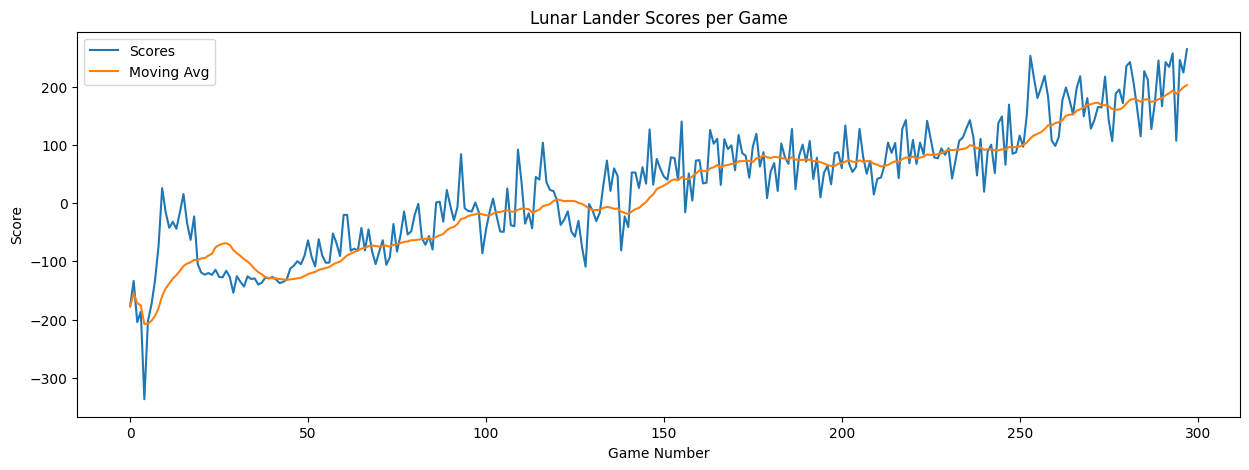

In [4]:
plt.figure(figsize=(15,5))
plt.plot(log["scores"], label="Scores")
plt.plot(log["running_avg_scores"], label="Moving Avg")
plt.title("Lunar Lander Scores per Game")
plt.xlabel("Game Number")
plt.ylabel("Score")
plt.legend()
plt.show()

### Comparing Different ENV Counts

I ran separately results from training with different number of environments to see how they work

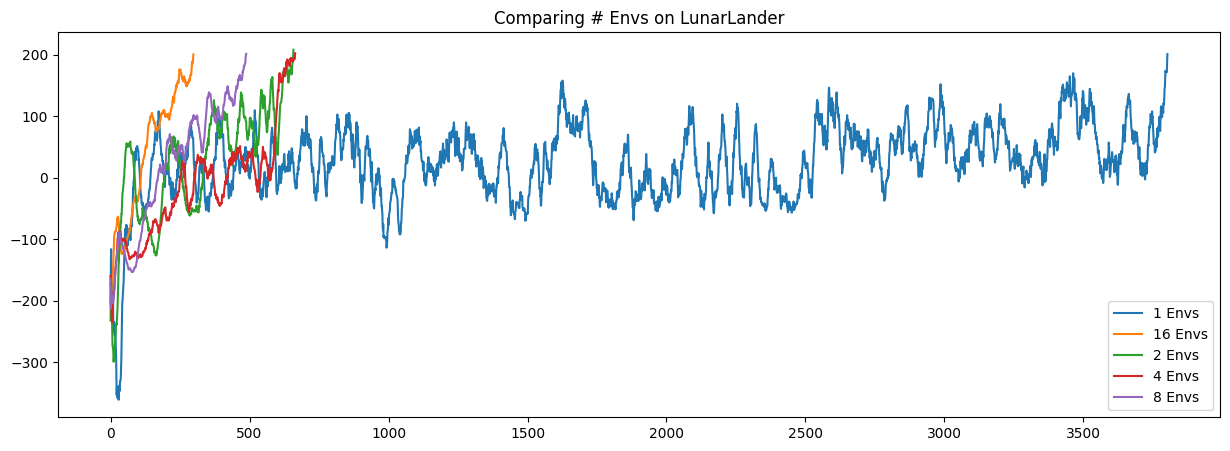

In [5]:
plt.figure(figsize=(15,5))
for file in os.listdir("results"):
    path_to_file = os.path.join("results", file)
    num_envs = int(file[5:].split(".")[0])

    with open(path_to_file, 'rb') as handle:
        log = pickle.load(handle)
    
    plt.plot(log["running_avg_scores"], label=f"{num_envs} Envs")

plt.title("Comparing # Envs on LunarLander")
plt.legend()
plt.show()


As we can see, with more environments running concurrently we can solve the environment much faster! This is because by averaging our loss over the different environments we get a better estimate! But the coolest part is just look how much better having 2 environments is than 1, that is a huge gain (and save in training time!)